# $^{83m}Kr$ Event Selection for XENON1T Flushing Mode
Dan Alexander, Ted Berger; Sept. ?, 2016

In [1]:
# Set name of notebook for folder to save plots in
notebook_name = 'Xe1T_Kr83m_EventSelect'

# To save plots to png and/or pdf, set to true
save_plots=False
save_pdf_plots=False

# to turn on and off the presentation plots
presentation_mode = False

# to set the print format of the tables (wiki : "^" , notebook: "|" )
wiki = False

In [2]:
# run imports
%run "/home/berget2/Documents/XeAnalysis/helpers/initialize_midway.ipynb"
import matplotlib.patches as patches

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


Initialization done, Notebook was last run on: 13/09/2016


In [3]:
# get all plotfunctions
%run "/home/berget2/Documents/XeAnalysis/helpers/plot_functions.ipynb"

In [ ]:
hax.ipython.code_hider()

# Table of Contents
[1 - Introduction](#introduction)  
[2 - Data](#data)  
[3 - Event Landscape](#landscape)  
[4 - The DoubleScatter Treemaker](#treemakers)  
[5 - Event Identification and Selection](#event_selection)  
[6 - Electron Lifetime](#electron_lifetime)  
[7 - Light Yield](#light_yield)  
[8 - Mixing](#mixing)  
[9 - LCE Maps](#lce_maps)  
[10 - References](#references)  

<a id='introduction'></a>
# Introduction

As an internal calibration, $^{83m}Kr$ proves very useful in a variety of liquid noble detectors. We utilize a solution of $^{83}Rb$ evaporated onto zeolite beads to generate $^{83m}Kr$ with a half-life of $86.2\ days$. From there, $^{83m}Kr$, with a half-life of $1.83\ hr$, generates a $32.1\ keV$ conversion electron, followed by a $9.4\ keV$ conversion electron with a delay half-life of $154.4\ ns$. This decay scheme is shown in Figure 0.

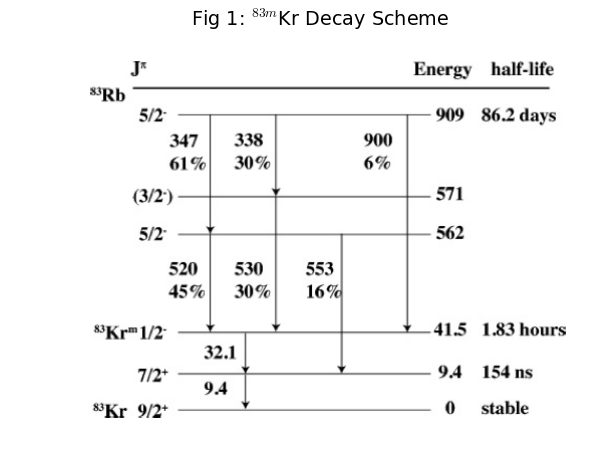

In [4]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)  

plt.imshow(mpimg.imread('../figures/kr83m_decay_scheme.png'))
plt.title('Fig 1: $^{83m}$Kr Decay Scheme')
plt.axis('off')
plt.show()

The short half-life of $^{83m}Kr$ and its mother permit an internal calibration without introducing unwanted signals into the experiment. Furthermore, the short half-life between the $32.1\ keV$ and $9.4\ keV$ calibration lines provides a unique signal that is essentially background free.

I'm not entirely sure what the focus or extent of this not will be yet ...

<a id='data'></a>
# Data

In [5]:
# Get pax values
pax_config = configuration.load_configuration('XENON1T')
n_channels = pax_config['DEFAULT']['n_channels']
pmts = pax_config['DEFAULT']['pmts']
tpc_height = pax_config['DEFAULT']['tpc_length']
tpc_radius = pax_config['DEFAULT']['tpc_radius']
gains = pax_config['DEFAULT']['gains']
busy_on_ch = pax_config['DEFAULT']['channels_in_detector']['busy_on'][0]

# Initialize hax
hax.__version__
hax.init(experiment='XENON1T',
         raw_data_access_mode='local',
         raw_data_local_path='/project/lgrandi/xenon1t/raw',
         main_data_paths=['/project/lgrandi/xenon1t/processed/pax_v5.6.2'],
         minitree_paths = ['/home/berget2/Documents/XeAnalysis/minitrees'])
         #pax_version_policy = 'loose') # only use for version problems

# Import minitrees
sys.path.append('/home/berget2/Documents/XeAnalysis/helpers/')
from DoubleScatter import *

In [6]:
datasets = [2047 + i for i in range(18)]
#datasets_bkg = [2004 + i for i in range(12)]

In [ ]:
# Get run names and rundoc info
run_names = {}
run_docs = {}
#dead_time = {}
busy_on = {}
for run_number in datasets:
    run_names[run_number] = hax.runs.datasets_query('number == %d' % run_number)[0]
    run_docs[run_number] = hax.runs.get_run_info(run_names[run_number])
#    dead_time[run_number] = hax.trigger_data.get_trigger_data(run_number, 'dead_time_info')['busy'].sum()
    busy_on[run_number] = hax.trigger_data.get_trigger_data(run_number, 'count_of_all_pulses')[:, busy_on_ch].sum()

In [ ]:
%%capture run_db_table_info
# Print the slowcontrol/rundb info for all datasets ( print run_db_table_info and copy paste in markdown cell)
water_offset = 0.36 # this we need to subtract from the SC value to get the physical level
average_gains = []
# for Ipython formatting
if not wiki:
    print('| Run number | Source | Date |  Events | Lifetime [h] | Cathode [kV] | Anode [V] '
          '| Liquid lvl [mm] | e lifetime [us] | LY [pe/keV] | PMT Voltage (av.) [V] | Water lvl [m] | Busy on [#] |') 
    print('| ----- | ----- | ----- | ----- | ----- | ----- |----- | ----- | ----- |----- | ----- | ----- | --- |')
# for wiki formatting
if wiki:
    print('^ Run number ^ Source ^ Date ^  Events ^ Lifetime [h] ^ Cathode [kV] ^ Anode [V] '
          '^ Liquid lvl [mm] ^ e lifetime [us] ^ LY [pe/keV] ^ Av. gains [2e6] ^ Water lvl [m] ^ Busy on [#] ^')
for run in datasets:
    print('| %i | %s | %s | %1.0f | %1.2f | %1.0f | %1.0f | %1.2f |%1.2f |%1.2f | %.1e | %1.1f | %1.0f | '% (
            run, 
            run_docs[run]['source']['type'],
            run_docs[run]['start'],
            run_docs[run]['trigger']['events_built'],  
            (run_docs[run]['end'] - run_docs[run]['start']).seconds/3600, 
            #run_docs[run]['slow_control']['field']['cathode_kV'], 
            -15,
            # get from comments
            run_docs[run]['slow_control']['field']['anode_V'],
            run_docs[run]['slow_control']['cryogenics']['Xe_height_above_gate_in_short_levelmeter_2_mm'],
            run_docs[run]['processor']['DEFAULT']['electron_lifetime_liquid']/units.us,
#             ly_fit(run_docs[run]['trigger']['end_trigger_processing_timestamp'])),
            float('nan'), # does not work untill we have the light yield fit
            np.average([voltage for voltage in run_docs[datasets[0]]['slow_control']['pmts'].values()]),
            # take average voltage instead of gain
#             np.average(run_docs[run]['processor']['DEFAULT']['gains']),
            run_docs[run]['slow_control']['water']['water_level_m']-water_offset,
            busy_on[run]))

In [ ]:
#print(run_db_table_info)

### Table 1: Kr83m Flushing Mode Data
| Run number | Source | Date |  Events | Lifetime [h] | Cathode [kV] | Anode [V] | Liquid lvl [mm] | e lifetime [us] | LY [pe/keV] | PMT Voltage (av.) [V] | Water lvl [m] | Busy on [#] |
| ----- | ----- | ----- | ----- | ----- | ----- |----- | ----- | ----- |----- | ----- | ----- | --- |
| 2047 | Kr83m | 2016-08-10 14:08:14 | 36271 | 1.00 | -15 | 4002 | 2.76 |309.67 |nan | 1.3e+03 | 9.7 | 3602 | 
| 2048 | Kr83m | 2016-08-10 15:08:23 | 96958 | 1.00 | -15 | 4002 | 2.70 |309.74 |nan | 1.3e+03 | 9.7 | 153465 | 
| 2049 | Kr83m | 2016-08-10 16:08:32 | 54196 | 0.55 | -15 | 4002 | 2.63 |310.32 |nan | 1.3e+03 | 9.7 | 3324 | 
| 2050 | Kr83m | 2016-08-10 16:41:56 | 33104 | 0.33 | -15 | 4002 | 2.68 |310.36 |nan | 1.3e+03 | 9.7 | 2175 | 
| 2051 | Kr83m | 2016-08-10 17:02:08 | 33438 | 0.33 | -15 | 4002 | 2.60 |310.39 |nan | 1.3e+03 | 9.7 | 2400 | 
| 2052 | Kr83m | 2016-08-10 17:22:20 | 101543 | 1.00 | -15 | 4002 | 2.63 |309.91 |nan | 1.3e+03 | 9.7 | 7683 | 
| 2053 | Kr83m | 2016-08-10 18:22:42 | 101634 | 1.00 | -15 | 4002 | 2.75 |310.48 |nan | 1.3e+03 | 9.7 | 8369 | 
| 2054 | Kr83m | 2016-08-10 19:23:08 | 103056 | 1.00 | -15 | 4002 | 2.71 |310.05 |nan | 1.3e+03 | 9.7 | 8665 | 
| 2055 | Kr83m | 2016-08-10 20:23:30 | 103770 | 1.00 | -15 | 4002 | 2.73 |310.62 |nan | 1.3e+03 | 9.7 | 32409 | 
| 2056 | Kr83m | 2016-08-10 21:23:41 | 104628 | 1.00 | -15 | 4002 | 2.69 |310.20 |nan | 1.3e+03 | 9.7 | 13840 | 
| 2057 | Kr83m | 2016-08-10 22:23:57 | 105816 | 1.00 | -15 | 4002 | 2.78 |310.27 |nan | 1.3e+03 | 9.7 | 213241 | 
| 2058 | Kr83m | 2016-08-10 23:24:08 | 109243 | 1.00 | -15 | 4002 | 2.64 |310.83 |nan | 1.3e+03 | 9.7 | 97829 | 
| 2059 | Kr83m | 2016-08-11 00:24:24 | 112575 | 1.00 | -15 | 4002 | 2.67 |310.90 |nan | 1.3e+03 | 9.7 | 7746 | 
| 2060 | Kr83m | 2016-08-11 01:24:36 | 113924 | 1.00 | -15 | 4002 | 2.71 |310.97 |nan | 1.3e+03 | 9.7 | 9157 | 
| 2061 | Kr83m | 2016-08-11 02:24:48 | 114274 | 1.00 | -15 | 4002 | 2.70 |311.03 |nan | 1.3e+03 | 9.7 | 11514 | 
| 2062 | Kr83m | 2016-08-11 03:25:01 | 114116 | 1.00 | -15 | 4002 | 2.70 |310.62 |nan | 1.3e+03 | 9.7 | 7051 | 
| 2063 | Kr83m | 2016-08-11 04:25:14 | 114529 | 1.00 | -15 | 4002 | 2.61 |310.69 |nan | 1.3e+03 | 9.7 | 2333 | 
| 2064 | Kr83m | 2016-08-11 05:25:36 | 114036 | 1.00 | -15 | 4002 | 2.65 |311.24 |nan | 1.3e+03 | 9.7 | 5173 | 

In [7]:
# Total lifetime computation
lifetime_sec = 0
for run_number in datasets:
    rundoc = hax.runs.get_run_info(run_number)
    lifetime_sec += (rundoc['end'] - rundoc['start']).seconds
print("Total lifetime: %0.2f h" % (lifetime_sec / 3600))

Total lifetime: 16.24 h


In [8]:
# run hax, load minitrees

# Kr83m flushing mode
data = hax.minitrees.load(datasets, ['Basics',DoubleScatter])
print('We loaded %i datasets where we have found %i events' % (len(datasets),len(data)))

# background
# data_bkg = hax.minitrees.load(datasets_bkg, ['Basics',DoubleScatter])
# print('We loaded %i background datasets where we have found %i events' % (len(datasets_bkg),len(data_bkg)))

We loaded 18 datasets where we have found 1667111 events


<a id='landscape'></a>
# $^{83m}Kr$ Flushing Mode Event Landscape

Before specifically searching for $^{83m}Kr$ events we take a broad view of all events showing up in our flushing mode data. Figure 2 presents a S2-only interpretation of events showing up in Xe1T for $^{83m}Kr$ flushing mode data alongside Jelle's comparable figure and description of background data.

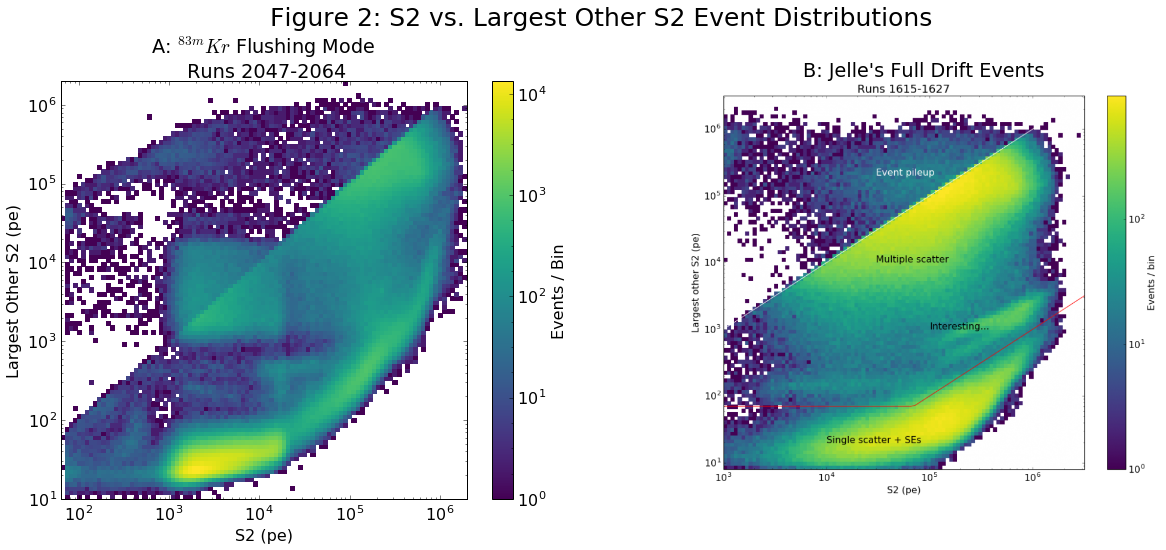

In [9]:
fig = plt.figure(figsize = (20,8))
fig.suptitle('Figure 2: S2 vs. Largest Other S2 Event Distributions', size = 25)
plt.subplots_adjust(top=0.85)

plt.subplot(121)
h_s2s_basics = Histdd(data['s2'].values,
            data['largest_other_s2'].values,
            axis_names=['S2 (pe)', 'Largest Other S2 (pe)'],
            bins=[np.logspace(1.8,6.3,100),np.logspace(1,6.3,100)],)
h_s2s_basics.plot(cblabel = 'Events / Bin', log_scale = True)
plt.xscale('log')
plt.yscale('log')
plt.title('A: $^{83m}Kr$ Flushing Mode \n Runs 2047-2064')

plt.subplot(122)
plt.imshow(mpimg.imread('../figures/Jelle_first_full_drift_events.png'))
plt.title('B: Jelle\'s Full Drift Events')
plt.axis('off')

plt.show()

Well this is a crap shoot, lets move on.

Next we consider the position distribution of all events, shown in Figure 3.

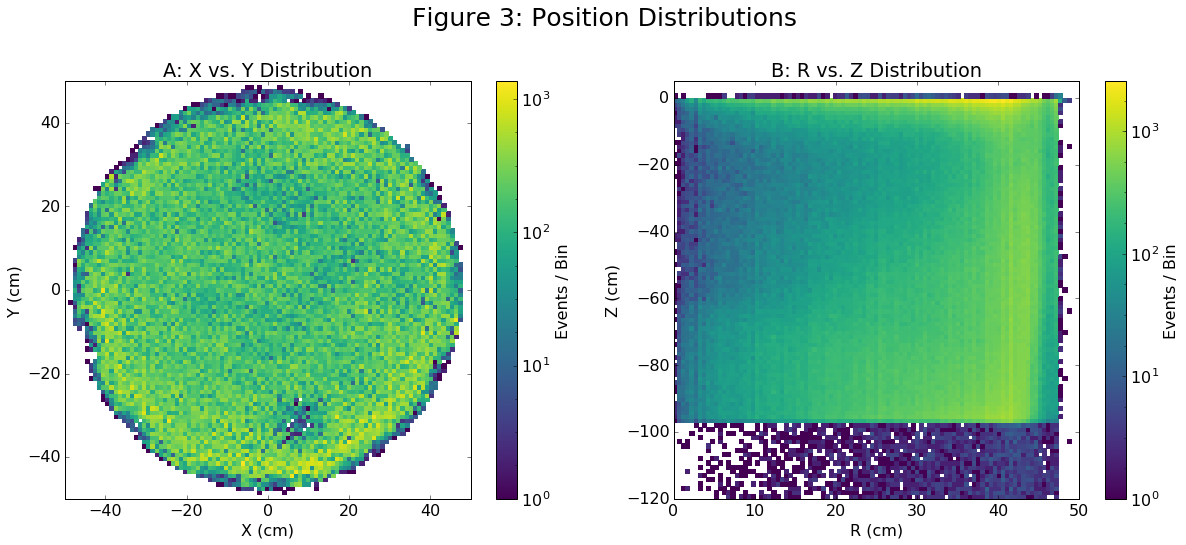

In [10]:
fig = plt.figure(figsize = (20,8))
fig.suptitle('Figure 3: Position Distributions', size = 25)
plt.subplots_adjust(top=0.85)

plt.subplot(121)
h_xy_basics = Histdd(data['x'].values,
            data['y'].values,
            axis_names=['X (cm)', 'Y (cm)'],
            bins=[np.linspace(-50,50,100),np.linspace(-50,50,100)],)
h_xy_basics.plot(cblabel = 'Events / Bin', log_scale = True)
plt.title('A: X vs. Y Distribution')

plt.subplot(122)
h_rz_basics = Histdd(np.sqrt(data['x'].values**2+data['y'].values**2),
            data['z'].values,
            axis_names=['R (cm)', 'Z (cm)'],
            bins=[np.linspace(0,50,100),np.linspace(-120,5,100)],)
h_rz_basics.plot(cblabel = 'Events / Bin', log_scale = True)
plt.title('B: R vs. Z Distribution')

plt.show()

* There seems to be a PMT out near $(x,y)=(10\ cm,-30\ cm)$
* Z-position reconstruction is still bad, probably a bad drift velocity in pax config

Next we re-scale the z-positions such that the max drift time places events just att he bottom of the TPC; this process is demonstrated in Figure 4.

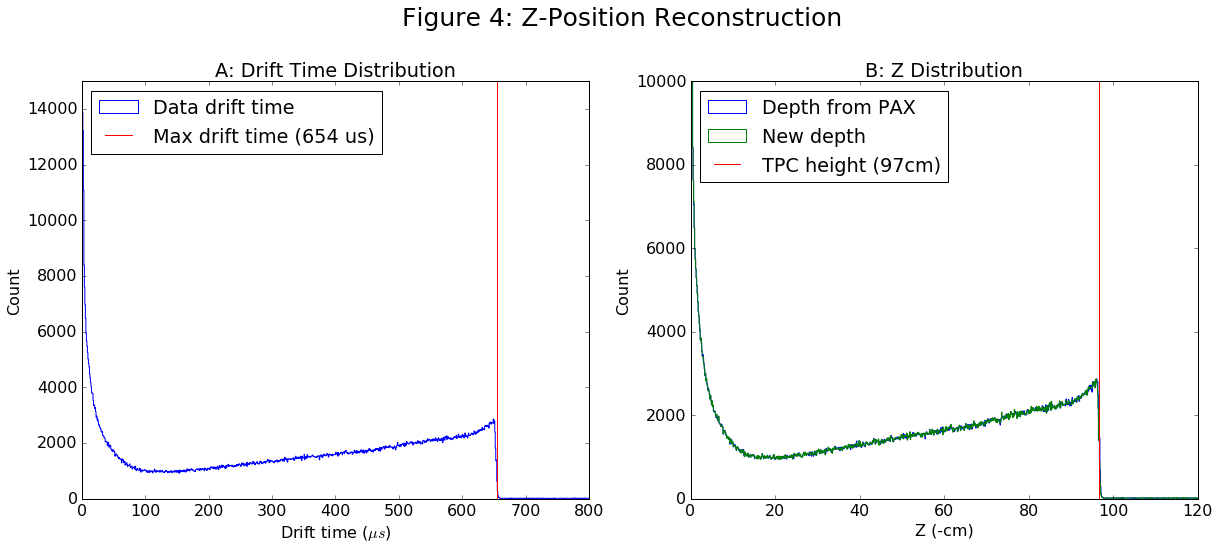

In [11]:
self_set_max_drift_time = 654000 # ns

fig = plt.figure(figsize = (20,8))
fig.suptitle('Figure 4: Z-Position Reconstruction', size = 25)
plt.subplots_adjust(top=0.85)

plt.subplot(121)
_title = '  '
_xrange = [0,0.8e3]
_linestyle = 'solid'
_bins = 1000
plt.hist(data['drift_time'].values/units.us, bins = _bins, label = 'Data drift time', color = 'blue', 
         histtype = 'step', linestyle = _linestyle, range = _xrange)
plt.vlines(self_set_max_drift_time/units.us,0,35000, color = 'red', label = 'Max drift time (654 us)')
plt.legend(loc = 'upper left')
plt.xlabel('Drift time ($\mu s$)')
plt.ylabel('Count')
plt.ylim(0,15e3)
plt.title('A: Drift Time Distribution')

plt.subplot(122)
_title = '  '
_xrange = [0,120]
_linestyle = 'solid'
_bins = 1000
plt.hist(-data['z'].values, bins = _bins, label = 'Depth from PAX', color = 'blue', 
         histtype = 'step', linestyle = _linestyle, range = _xrange)

# Calculate new z
data['z_good'] = (data['drift_time']/self_set_max_drift_time)*-tpc_height # cm
plt.hist(-data['z_good'].values, bins = _bins, label = 'New depth', color = 'green', 
         histtype = 'step', linestyle = _linestyle, range = _xrange)

plt.vlines(tpc_height,0,1e4, color = 'red', label = 'TPC height (%.0fcm)' % tpc_height)
plt.legend(loc = 'upper left')
plt.xlabel('Z (-cm)')
plt.ylabel('Count')
plt.ylim(0,1e4)
plt.title('B: Z Distribution')

plt.show()

* Z-positions correct!

Finally we identify and isolate alpha events from background, shown in Figure 5.

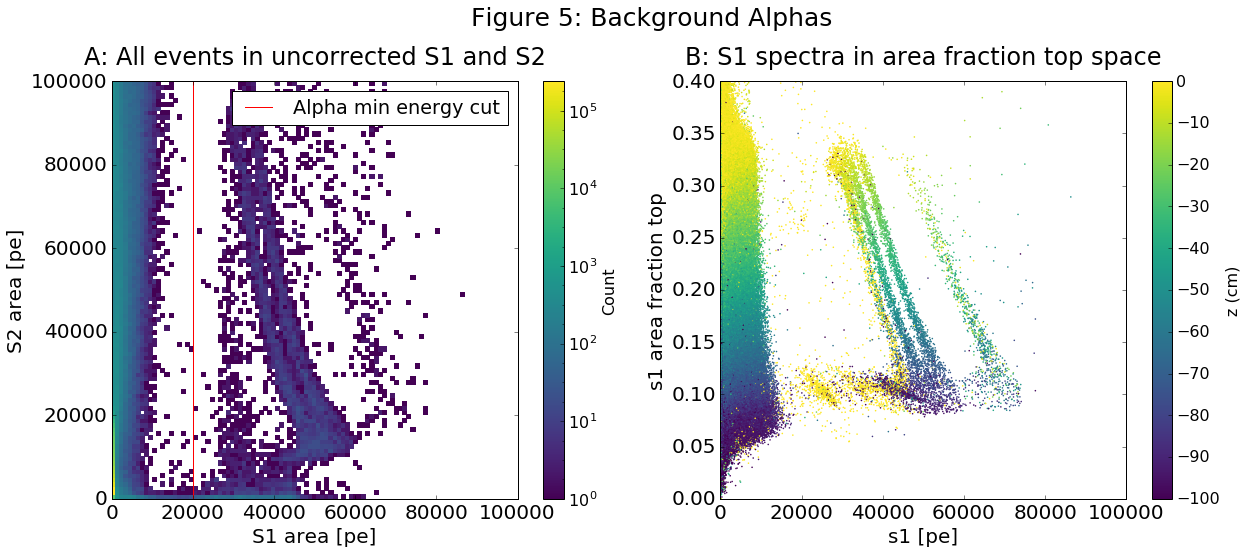

In [12]:
fig = plt.figure(figsize = (20,8))
fig.suptitle('Figure 5: Background Alphas', size = 25)
plt.subplots_adjust(top=0.85)

plt.subplot(121)
_title = 'A: All events in uncorrected S1 and S2'
m2 = Histdd(data['s1'].values, data['s2'].values,
            axis_names=['S1 (pe)', 'S2 (pe)'],
            bins=[np.linspace(0,1e5,100),np.linspace(0,1e5,100)],)
m2.plot(cblabel = 'Count', log_scale = True)
set_axis('S1 area [pe]','S2 area [pe]',_title)
plt.vlines(2e4,0,1e5, color = 'red', label = 'Alpha min energy cut')
# save_plot(_title)
plt.legend(loc = 'upper right')

plt.subplot(122)
plot_scatter(data['s1'].values, data['s1_area_fraction_top'].values,'s1 [pe]', 's1 area fraction top', 'B: S1 spectra in area fraction top space', 
            xlim = [0,1e5],ylim = [0,0.4], c = data['z'].values,
             colorb = True, colorblabel = 'z (cm)',s = 10, 
             marker = '.', edgecolors ='none',
             vmin = -100, vmax = 0, grid = False)

* All four radon isotope lines ($^{210}Po$, $^{222}Rn$, $^{218}Po$, and $^{214}Po$) are clearly visble and all happen throughout the depth of the detector
* The two most dominant lines are from $^{222}Rn$ and $^{218}Po$. The shape of these lines is caused by at least two effect: 1. S1s from interactions deeper in the TPC will have a higher LCE and are thus bigger in area. 2. S2s from interactions deeper in the TPC will loose more electrons to impurities and will thus become smaller in area.
* The alpha_min_energy_cut roughly removes this background data

<a id='treemakers'></a>
# The DoubleScatter Treemaker

We now make the steps to identify double scatter events, the signature of the $^{83m}Kr$ calibration. The DoubleScatter treemaker identifies events with two s1s as follows:
* First S1 (s10) attributed to interactions[0]
* Additional interaction required for second S1 (s11)
 * Prioritize 2nd interaction with S1 and S2 distinct from interaction[0]
 * Otherwise select interaction with S1 distinct from interactions[0] but identical S2
* interactions re-ordered by S1 hit_time_mean
* Positions (x,y,z) pulled from interactions (e.g. interactions[0].x)
 
** Note: ** This places a strict requirement of two S1s and at least one S2
** Note: ** We also immediately apply a full-TPC fiducial cut requiring both interactions to provide positions within the TPC volume

In [13]:
# Add time and space differences of DoubleScatter events
data['s1_dt_hit_time_mean'] = data['s1_1_hit_time_mean'] - data['s1_0_hit_time_mean']
data['s1_dt_center_time'] = data['s1_1_center_time'] - data['s1_0_center_time']
data['int_dx'] = np.sqrt( (data['int_0_x'] - data['int_1_x'])**2
                         +(data['int_0_y'] - data['int_1_y'])**2
                         +(data['int_0_z'] - data['int_1_z'])**2 )
data['int_dxy'] = np.sqrt( (data['int_0_x'] - data['int_1_x'])**2
                         +(data['int_0_y'] - data['int_1_y'])**2 )
data['int_dz'] = np.abs( data['int_0_z'] - data['int_1_z'] )

# Add S1_ratio
data['s1_ratio'] = data['s1_1']/data['s1_0']

In [14]:
# DoubleScatter selection

# apply TPC figucial cut, also removes NANs
data_ds = data[ (data['int_0_z'] <= 0.0) & (data['int_0_z'] >= -tpc_height)
              & (data['int_0_x']**2 + data['int_0_y']**2 <= tpc_radius**2)
              & (data['int_1_z'] <= 0.0) & (data['int_1_z'] >= -tpc_height)
              & (data['int_1_x']**2 + data['int_1_y']**2 <= tpc_radius**2)]
print('We found %i DoubleScatter events out of %i total events \n DoubleScatter acceptance = %f' 
      % (len(data_ds),len(data),len(data_ds)/len(data)))

We found 327469 DoubleScatter events out of 1667111 total events 
 DoubleScatter acceptance = 0.196429


In an effort to understand the performance of the DoubleScatter treemaker first we consider the classic S1_0 vs. S1_1 parameter space, comparing DoubleScatter to Basics variables. The results are presented in Figure 6.

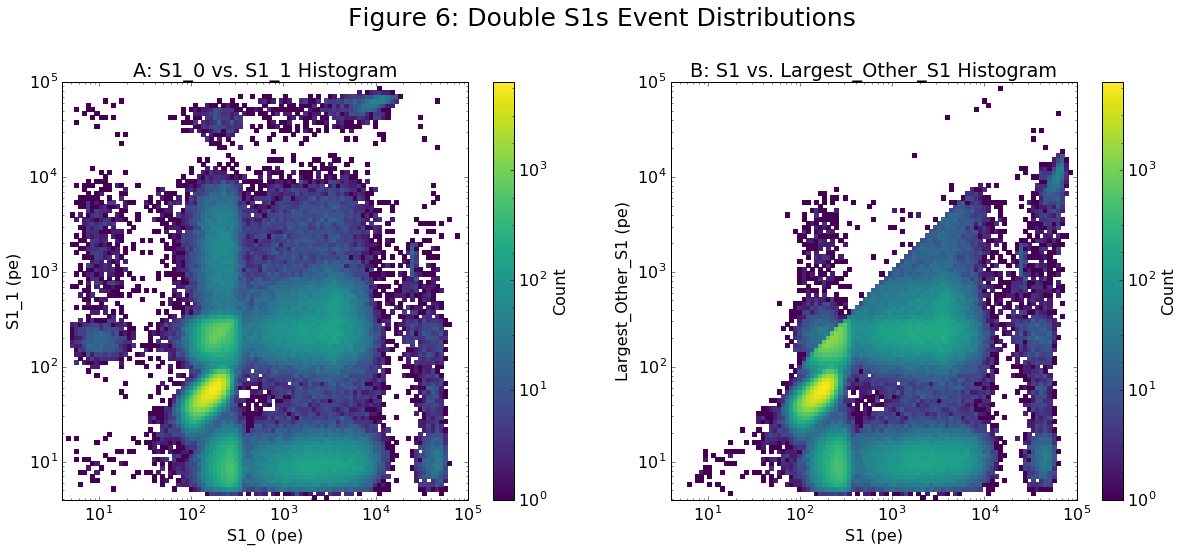

In [27]:
fig = plt.figure(figsize = (20,8))
fig.suptitle('Figure 6: Double S1s Event Distributions', size = 25)
plt.subplots_adjust(top=0.85)

plt.subplot(121)
h_s1s = Histdd(data_ds['s1_0'].values,
            data_ds['s1_1'].values,
            axis_names=['S1_0 (pe)', 'S1_1 (pe)'],
            bins=[np.logspace(0.6,5,100),np.logspace(0.6,5,100)],)
h_s1s.plot(cblabel = 'Count', log_scale = True)
plt.xscale('log')
plt.yscale('log')
plt.title('A: S1_0 vs. S1_1 Histogram')

plt.subplot(122)
h_s1s = Histdd(data_ds['s1'].values,
            data_ds['largest_other_s1'].values,
            axis_names=['S1 (pe)', 'Largest_Other_S1 (pe)'],
            bins=[np.logspace(0.6,5,100),np.logspace(0.6,5,100)],)
h_s1s.plot(cblabel = 'Count', log_scale = True)
plt.xscale('log')
plt.yscale('log')
plt.title('B: S1 vs. Largest_Other_S1 Histogram')

plt.show()

* The DoubleScatter variables have broken the degeneracy in the Basics variables caused by ordering peaks by size; is this the correct behavior?
* Several event distributions are present, we should figure out what they are

Next we consider events with distinct S2s as determined by DoubleScatter, shown in Figure 7.

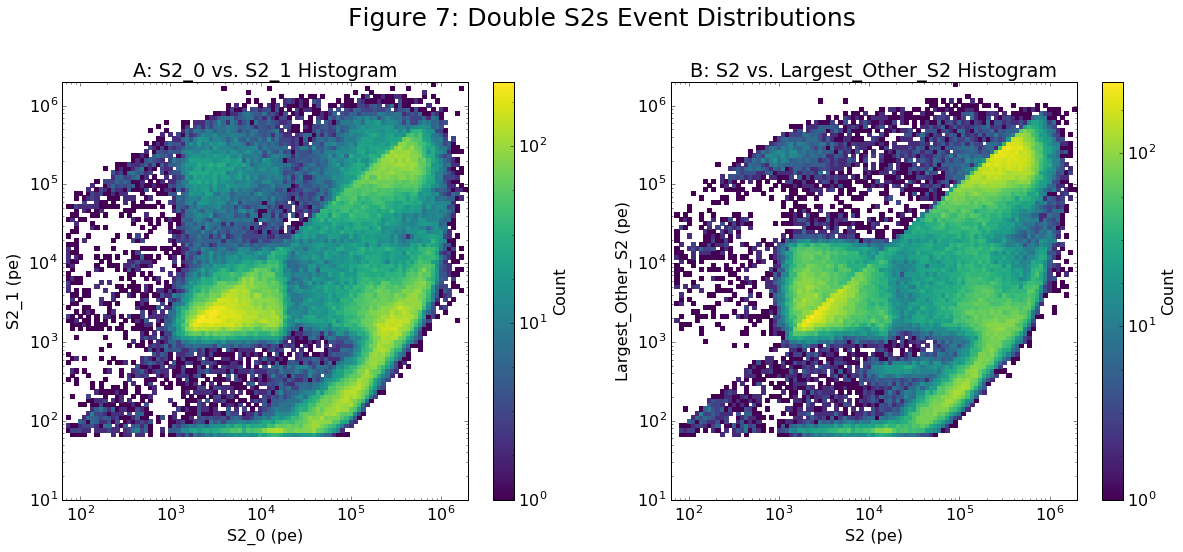

In [28]:
data_2s2s = data_ds[ data_ds['secondS2']==1 ]

fig = plt.figure(figsize = (20,8))
fig.suptitle('Figure 7: Double S2s Event Distributions', size = 25)
plt.subplots_adjust(top=0.85)

plt.subplot(121)
h_s2s = Histdd(data_2s2s['s2_0'].values,
            data_2s2s['s2_1'].values,
            axis_names=['S2_0 (pe)', 'S2_1 (pe)'],
            bins=[np.logspace(1.8,6.3,100),np.logspace(1,6.3,100)],)
h_s2s.plot(cblabel = 'Count', log_scale = True)
plt.xscale('log')
plt.yscale('log')
plt.title('A: S2_0 vs. S2_1 Histogram')

plt.subplot(122)
h_s2s = Histdd(data_2s2s['s2'].values,
            data_2s2s['largest_other_s2'].values,
            axis_names=['S2 (pe)', 'Largest_Other_S2 (pe)'],
            bins=[np.logspace(1.8,6.3,100),np.logspace(1,6.3,100)],)
h_s2s.plot(cblabel = 'Count', log_scale = True)
plt.xscale('log')
plt.yscale('log')
plt.title('B: S2 vs. Largest_Other_S2 Histogram')

plt.show()

* Degeneracy not completely removed due to imperfect interaction s1-s2 pairing

The DoubleScatter variables also give us access to differences between the first and second (time-ordered) events. Figure 8 shows the spatial differences between the DoubleScatter events, with the $(x,y)$ difference and $z$ difference considered separately due to the potential for mismatched peaks. 

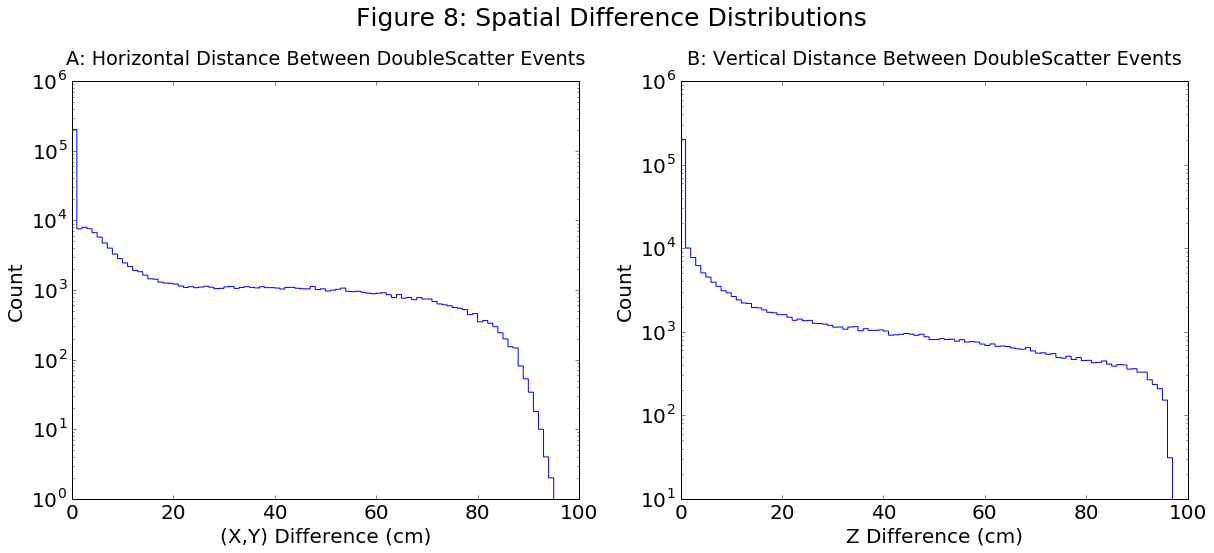

In [31]:
fig = plt.figure(figsize = (20,8))
fig.suptitle('Figure 8: Spatial Difference Distributions', size = 25)
plt.subplots_adjust(top=0.85)

plt.subplot(121)
_title = '  '
plt.hist(data_ds['int_dxy'].values, bins = 100, color = 'blue', 
          histtype = 'step', linestyle = 'solid', range = [0,100])
set_axis('(X,Y) Difference (cm)', 'Count',_title)
plt.yscale('log', nonposy='clip')
plt.title('A: Horizontal Distance Between DoubleScatter Events')

plt.subplot(122)
_title = '  '
plt.hist(data_ds['int_dz'].values, bins = 100, color = 'blue', 
          histtype = 'step', linestyle = 'solid', range = [0,100])
set_axis('Z Difference (cm)', 'Count',_title)
plt.yscale('log', nonposy='clip')
plt.title('B: Vertical Distance Between DoubleScatter Events')

plt.show()

* Many events are reconstructed on top of each other, which is what we expect

Finally, Figure 9 shows the time difference between the DoubleScatter events. Afterpulse lines are taken from the measured values of [Daniel Mayani's Afterpule Ion Identification Note](https://xecluster.lngs.infn.it/dokuwiki/doku.php?id=xenon:xenon1t:dsg:sensors:r11410:ion_id_afterpulses).

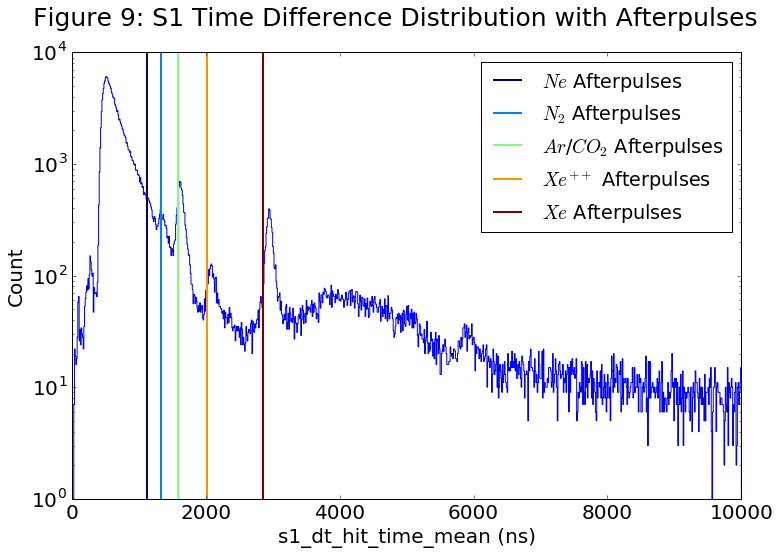

In [23]:
fig = plt.figure(figsize = (12,8))
fig.suptitle('Figure 9: S1 Time Difference Distribution with Afterpulses', size = 25)

_title = '  '
plt.hist(data['s1_dt_hit_time_mean'].values, bins = 1000, color = 'blue', 
          histtype = 'step', linestyle = 'solid', range = [0,1e4])
set_axis('s1_dt_hit_time_mean (ns)', 'Count',_title)
plt.yscale('log', nonposy='clip')
plt.vlines(1130,0,1e4, color = plt.cm.jet(0), label = '$Ne$ Afterpulses', linewidth = 2)
plt.vlines(1330,0,1e4, color = plt.cm.jet(0.25), label = '$N_2$ Afterpulses', linewidth = 2)
plt.vlines(1580,0,1e4, color = plt.cm.jet(0.5), label = '$Ar$/$CO_2$ Afterpulses', linewidth = 2)
plt.vlines(2020,0,1e4, color = plt.cm.jet(0.75), label = '$Xe^{++}$ Afterpulses', linewidth = 2)
plt.vlines(2850,0,1e4, color = plt.cm.jet(1.0), label = '$Xe$ Afterpulses', linewidth = 2)
plt.legend(loc = 'upper right')

plt.show()

* $^{83m}Kr$ Decay very evident in $\text{s1_dt_hit_time_mean} \in [500,1000]$
* Afterpulse guesses for visible peaks are slightly low
* Afterpulses in $^{83m}Kr$ Decay/rolloff are not visible ($H$, $H_2$, $He$, and $CH_4$ at 280, 390, 520, and 1010 ns resp.)

<a id='event_selection'></a>
# Event Identification and Selection

## Alphas
To begin our search for $^{83m}Kr$ within DoubleScatter events we apply the alpha_min_energy_cut of Figure 5 to both S1s. This data and cut are demonstrated in Figure 10.

In [ ]:
data_ds_noAlpha = data_ds[ (data_ds['s1_0']<2e4) & (data_ds['s1_1']<2e4) ]

In [ ]:
data_bkg_ds_noAlpha = data_bkg_ds[ (data_bkg_ds['s1_0']<2e4) & (data_bkg_ds['s1_1']<2e4) ]

In [ ]:
fig = plt.figure(figsize = (12,8))
fig.suptitle('Figure 10: DoubleScatter Events Alpha_Min_Energy_Cut', size = 25)

h_s1s = Histdd(data_ds['s1_0'].values,
            data_ds['s1_1'].values,
            axis_names=['S1_0 (pe)', 'S1_1 (pe)'],
            bins=[np.logspace(0.6,5,100),np.logspace(0.6,5,100)],)
h_s1s.plot(cblabel = 'Count (Cut Events)', log_scale = True, alpha=0.5)

h_s1s_noAlpha = Histdd(data_ds_noAlpha['s1_0'].values,
            data_ds_noAlpha['s1_1'].values,
            axis_names=['S1_0 (pe)', 'S1_1 (pe)'],
            bins=[np.logspace(0.6,5,100),np.logspace(0.6,5,100)],)
h_s1s_noAlpha.plot(cblabel = 'Count (Selected Events)', log_scale = True)

plt.vlines(2e4,0,1e5, color = 'red', label = 'alpha_min_energy_cut')
plt.hlines(2e4,0,1e5, color = 'red')
plt.legend(loc = 'upper left', fontsize = 12)

plt.xscale('log')
plt.yscale('log')

plt.show()

In [ ]:
fig = plt.figure(figsize = (12,8))
fig.suptitle('S1_0 vs. S1_1 with S1_dt Colorscale', size = 25)

plt.xscale('log')
plt.yscale('log')

plot_scatter(data_ds_noAlpha['s1_0'].values, data_ds_noAlpha['s1_1'].values,'s1_0 [pe]', 's1_1 [pe]', '', 
            xlim = [0,2e4],ylim = [0,2e4], c = data_ds_noAlpha['s1_dt_center_time'].values,
             colorb = True, colorblabel = 's1_dt (ns)',s = 10, 
             marker = '.', edgecolors ='none',
             vmin = 0, vmax = 8000, grid = False)



In [ ]:
len(data_ds_noAlpha[ data_ds_noAlpha['s2_0_center_time'] > data_ds_noAlpha['s1_0_center_time'] ])/len(data_ds_noAlpha)

In [ ]:
fig = plt.figure(figsize = (12,8))
fig.suptitle('Background S1_0 vs. S1_1 with S1_dt Colorscale', size = 25)

plt.xscale('log')
plt.yscale('log')

plot_scatter(data_bkg_ds_noAlpha['s1_0'].values, data_bkg_ds_noAlpha['s1_1'].values,'s1_0 [pe]', 's1_1 [pe]', '', 
            xlim = [0,2e4],ylim = [0,2e4], c = data_bkg_ds_noAlpha['s1_dt_center_time'].values,
             colorb = True, colorblabel = 's1_dt (ns)',s = 10, 
             marker = '.', edgecolors ='none',
             vmin = 0, vmax = 5000, grid = False)



# Event Distributions

In [ ]:
fig = plt.figure(figsize = (12,8))
fig.suptitle('Figure ??: DoubleScatter Events: Distributions', size = 25)

h_s1s = Histdd(data_ds['s1_0'].values,
            data_ds['s1_1'].values,
            axis_names=['S1_0 (pe)', 'S1_1 (pe)'],
            bins=[np.logspace(0.6,5,100),np.logspace(0.6,5,100)],)
h_s1s.plot(cblabel = 'Count (Cut Events)', log_scale = True, alpha=0.5)

h_s1s_noAlpha = Histdd(data_ds_noAlpha['s1_0'].values,
            data_ds_noAlpha['s1_1'].values,
            axis_names=['S1_0 (pe)', 'S1_1 (pe)'],
            bins=[np.logspace(0.6,5,100),np.logspace(0.6,5,100)],)
h_s1s_noAlpha.plot(cblabel = 'Count (Selected Events)', log_scale = True)

plt.vlines(2e4,0,1e5, color = 'red', label = 'alpha_min_energy_cut')
plt.hlines(2e4,0,1e5, color = 'red')
plt.legend(loc = 'upper left', fontsize = 12)

plt.xscale('log')
plt.yscale('log')

currentAxis = plt.gca()
currentAxis.add_patch( patches.Rectangle( (120.0, 40.0), 100.0, 40.0, fill=False ))
currentAxis.add_patch( patches.Rectangle( (150.0, 6.0), 150.0, 8.0, fill=False ))
currentAxis.add_patch( patches.Rectangle( (600.0, 6.0), 9.4e3, 8.0, fill=False ))
currentAxis.add_patch( patches.Rectangle( (6.0, 150.0), 8.0, 150.0, fill=False ))
currentAxis.add_patch( patches.Rectangle( (6.0, 600.0), 8.0, 9.4e3, fill=False ))
currentAxis.add_patch( patches.Rectangle( (150.0, 150.0), 150.0, 150.0, fill=False ))
currentAxis.add_patch( patches.Rectangle( (600.0, 150.0), 9.4e3, 150.0, fill=False ))
currentAxis.add_patch( patches.Rectangle( (150.0, 600.0), 150.0, 9.4e3, fill=False ))
currentAxis.add_patch( patches.Rectangle( (1e3, 1e3), 9e3, 9e3, fill=False ))


plt.show()

In [ ]:
ranges = [ [[120,220],[40,80]],
           [[150,300],[6,14]],
           [[600,1e4],[6,14]],
           [[6,14],[150,300]],
           [[6,14],[600,1e4]],
           [[150,300],[150,300]],
           [[600,1e4],[150,300]],
           [[150,300],[600,1e4]],
           [[1e3,1e4],[1e3,1e4]] ]
labels = ['A','B','C','D','E','F','G','H','I']
dists = []
for r in ranges:
    dists.append( data_ds_noAlpha[ (data_ds_noAlpha['s1_0'] > r[0][0]) & 
                                   (data_ds_noAlpha['s1_0'] < r[0][1]) & 
                                   (data_ds_noAlpha['s1_1'] > r[1][0]) & 
                                   (data_ds_noAlpha['s1_1'] < r[1][1]) ] )

In [ ]:
fig = plt.figure(figsize = (12,8))
fig.suptitle('Figure ??: S1 Time Difference: Distributions', size = 25)

_title = '  '
# plt.hist(data['s1_dt_hit_time_mean'].values, bins = 1000, color = 'blue', 
#           histtype = 'step', linestyle = 'solid', range = [0,4e3])
# set_axis('s1_dt_hit_time_mean (ns)', 'Count',_title)

for i, dist in enumerate(dists):
    plt.hist(dist['s1_dt_hit_time_mean'].values, bins = 1000, histtype = 'step', range=[0,4e3], label = labels[i])

plt.yscale('log', nonposy='clip')
plt.legend(loc = 'upper right')
plt.ylim((3,3e3))

plt.show()

<a id='electron_lifetime'></a>
# Electron Lifetime

<a id='light_yield'></a>
# Light Yield

<a id='mixing'></a>
# Mixing

<a id='LCE Maps'></a>
# LCE Maps

<a id='references'></a>
# References